In [2]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)
import os
from os.path import join
import random
import itertools
import datetime
import numpy as np
import pylab
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, TimeDistributed, Multiply, BatchNormalization, Bidirectional, GlobalAveragePooling2D
from keras.layers import Reshape, Lambda, Flatten, Dropout, Concatenate, Permute, RepeatVector, GaussianNoise
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.recurrent import GRU, LSTM
from keras.optimizers import SGD, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
import cv2
from random import *
from math import pi
import hgtk
from PIL import ImageFont, Image, ImageDraw
from matplotlib import pyplot as plt
from collections import Counter
import datetime
import re
import OCR_utils as ocr

TensorFlow version: 1.10.0
Keras version: 2.2.0


In [3]:
kor_train = np.loadtxt('./text/train_kor_words.txt', dtype = np.str)
kor_test = np.loadtxt('./text/test_kor_words.txt', dtype = np.str)
eng_train = np.loadtxt('./text/train_eng_words.txt', dtype = np.str)
eng_test = np.loadtxt('./text/test_eng_words.txt', dtype = np.str)

In [4]:
random_seed=305
np.random.seed(random_seed)
tf.set_random_seed(random_seed)

text_length = 15
save_model_path = './generator_transfer.hdf5'

dictionary = ocr.load_dictionary()
font_path = "./fonts/"
font_list = os.listdir(font_path)

(6519, 32, 128, 1)


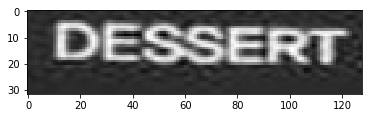

In [5]:
# 구글에서 '간판', '현수막' 등의 검색어로 crawling
# label과 cropping은 수작업으로 진행

n = 1000

train_path = './data/real_train.npz'
test_path = './data/real_test.npz'
X_train = np.load(train_path)['x']
X_test = np.load(test_path)['x']
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2],1))

X_train = np.array(X_train)/255
X_test = np.array(X_test)/255 

y_train = np.load(train_path)['y']
y_test = np.load(test_path)['y']
print(X_train.shape)
plt.imshow(X_test[n,:,:,0], cmap = 'gray')
plt.show()

In [6]:
# 생성데이터로 한 모델과 같은 구조 사용
# hdf5 file은 용량이 커서 올리지 않으나 2번에서 학습시킨 모델을 불러와서 사용
model = load_model('./generator_only.hdf5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 128, 1)   0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 32, 128, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 128, 64)  3200        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 64)  36928       conv2d_5[0][0]                   
                                                                 conv2d_1[0][0]                   
          

In [7]:
def handmade_generator(x,y,batch_size):
    length = len(x)
    rand_batch = np.random.choice(length,batch_size)
    batch_x = x[rand_batch]
    batch_y = y[rand_batch]
    
    aug = []
    for e in batch_x:
        if np.random.random() < 0.5:
            e = ocr.shift(e,10)
        if np.random.random() < 0.5:
            e = ocr.rotate(e,15)
        if np.random.random() < 0.5:
            e = ocr.g_blur(e,0.5)
        if np.random.random() < 0.5:
            e = ocr.reverse(e)
        if np.random.random() < 0.5:
            e = ocr.shrink(e,0.4)
        if np.random.random() < 0.5:
            e = ocr.tilt(e,20)
        aug.append(e)
    return(np.array(aug),batch_y)

In [8]:
# ocr.one_hot(바꿀 단어, 모델이 예측할 최대 음소 길이 (15이며 확장 가능), 음소 - one hot dictionary)

train_y_hot = ocr.one_hot(y_train,15,dictionary)
test_y_hot = ocr.one_hot(y_test,15,dictionary)

print(y_train[0])
print(train_y_hot[0])

아름다운
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
opt = keras.optimizers.SGD(lr=0.01,decay=0.00001, momentum = 0.5, nesterov = True)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
checkpoint_Best = ModelCheckpoint(filepath=save_model_path, verbose=0, save_best_only=True)


In [ ]:
# 실제 데이터 1번, 생성데이터 1번을 번갈아가면서 학습


train_generator = ocr.DataGenerator(batch_size=64, x_dim=(32,128), kor_source = kor_train, eng_source = eng_train, text_length = 15, dictionary = dictionary, font_path=font_path,text_generator = ocr.text_img_generator)
test_generator = ocr.DataGenerator(batch_size=500, x_dim=(32,128), kor_source = kor_test, eng_source = eng_test, text_length = 15, dictionary = dictionary, font_path=font_path,text_generator = ocr.text_img_generator)


epochs = 500
steps_per_epoch = 100
min_loss = 100

for epoch in range(epochs):
    dt1 = datetime.datetime.now()
    for step in range(steps_per_epoch):
        x_batch_gen, y_batch_gen = train_generator.data_generation()
        x_batch_real, y_batch_real= handmade_generator(X_train,train_y_hot,64)
        loss_gen = model.train_on_batch(x_batch_gen,y_batch_gen)
        loss_real = model.train_on_batch(x_batch_real, y_batch_real)
        
    test_loss, test_acc = model.evaluate(X_test,test_y_hot,verbose = 0)
    if test_loss < min_loss:
        min_loss = test_loss
        model.save(save_model_path)

    dt2 = datetime.datetime.now()
    time = dt2-dt1
    print ('epoch: %d, [Train_Loss: %.4f], [Train_Acc: %.2f Percent], [Test_Loss: %.4f], [Test_Acc: %.2f Percent], [Elapsed Time: %.2f Seconds]' % 
           (epoch+1, loss_real[0], 100*loss_real[1], test_loss, 100*test_acc, time.total_seconds()))

